# Sales Prediction

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load Dataset & Preprocessing

In [4]:
df = pd.read_csv(r"C:\Users\19457\OneDrive\Desktop\GrowLink Task\car_purchasing.csv", encoding="latin1")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer name     500 non-null    object 
 1   customer e-mail   500 non-null    object 
 2   country           500 non-null    object 
 3   gender            500 non-null    int64  
 4   age               500 non-null    float64
 5   annual Salary     500 non-null    float64
 6   credit card debt  500 non-null    float64
 7   net worth         500 non-null    float64
 8   sales_amount      500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 35.3+ KB


In [6]:
df = df.rename(columns={'car purchase amount': 'sales_amount'})

In [8]:
# Rename Gender Values: 0 → Male, 1 → Female
df['gender'] = df['gender'].replace({0: 'Male', 1: 'Female'})

In [9]:
# Add 'advertising_spend' as a percentage of annual salary
df['advertising_spend'] = df['annual Salary'] * np.random.uniform(0.05, 0.15)

In [10]:
# Add 'advertising_spend' as a percentage of annual salary
df['advertising_spend'] = df['annual Salary'] * np.random.uniform(0.05, 0.15)

In [11]:
# Define 'customer_segmentation' based on salary, debt, and net worth
conditions = [
    (df['annual Salary'] > 80000) & (df['credit card debt'] < 5000),
    (df['annual Salary'].between(40000, 80000)) & (df['credit card debt'].between(5000, 15000)),
    (df['annual Salary'] < 40000) & (df['credit card debt'] > 15000)
]
values = ['High-Value Customer', 'Mid-Tier Customer', 'Low-Value Customer']
df['customer_segmentation'] = np.select(conditions, values, default='Mid-Tier Customer')

In [12]:
# Assign 'promotions' based on net worth
df['promotions'] = pd.cut(df['net worth'], bins=3, labels=['Low', 'Medium', 'High'])

In [13]:
# Convert age column from float to integer (rounded)
df['age'] = df['age'].round().astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   customer name          500 non-null    object  
 1   customer e-mail        500 non-null    object  
 2   country                500 non-null    object  
 3   gender                 500 non-null    object  
 4   age                    500 non-null    int32   
 5   annual Salary          500 non-null    float64 
 6   credit card debt       500 non-null    float64 
 7   net worth              500 non-null    float64 
 8   sales_amount           500 non-null    float64 
 9   advertising_spend      500 non-null    float64 
 10  customer_segmentation  500 non-null    object  
 11  promotions             500 non-null    category
dtypes: category(1), float64(5), int32(1), object(5)
memory usage: 41.8+ KB


In [29]:
# Drop unnecessary columns (name, email)
df.drop(['customer name', 'customer e-mail'], axis=1, inplace=True)

In [30]:
print(df.head())

        country  gender  age  annual Salary  credit card debt    net worth  \
0      Bulgaria       1   42    62812.09301      11609.380910  238961.2505   
1        Belize       1   41    66646.89292       9572.957136  530973.9078   
2       Algeria       0   43    53798.55112      11160.355060  638467.1773   
3  Cook Islands       0   58    79370.03798      14426.164850  548599.0524   
4        Brazil       0   57    59729.15130       5358.712177  560304.0671   

   sales_amount  advertising_spend  customer_segmentation  promotions  
0   35321.45877        7319.852454                      2           1  
1   45115.52566        7766.743620                      2           2  
2   42925.70921        6269.452864                      2           2  
3   67422.36313        9249.444485                      2           2  
4   55915.46248        6960.579623                      2           2  


In [16]:
df.describe()

,age,annual Salary,credit card debt,net worth,sales_amount,advertising_spend
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,46.224000,62127.239608,9607.645049,431475.713625,44209.799218,7240.042570
std,7.990339,11703.378228,3489.187973,173536.756340,10773.178744,1363.861603
min,20.000000,20000.000000,100.000000,20000.000000,9000.000000,2330.714390
25%,41.000000,54391.977195,7397.515792,299824.195900,37629.896040,6338.608199
50%,46.000000,62915.497035,9655.035568,426750.120650,43997.783390,7331.902716
75%,52.000000,70117.862005,11798.867487,557324.478725,51254.709517,8171.235500
max,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000,11653.571952


## Handle Missing Values & Outliers


In [31]:
# Check missing values after handling
print(df.isnull().sum())

country                  0
gender                   0
age                      0
annual Salary            0
credit card debt         0
net worth                0
sales_amount             0
advertising_spend        0
customer_segmentation    0
promotions               0
dtype: int64


In [18]:
# Detect and remove outliers using Z-score
from scipy.stats import zscore
df = df[(np.abs(zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

## Data Visualization (EDA)

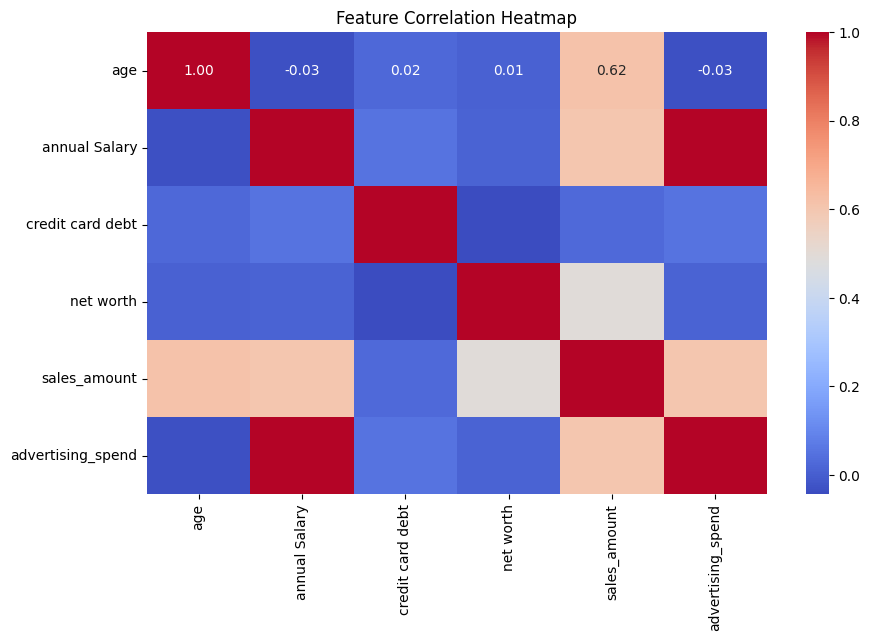

In [20]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

C:\Users\19457\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\19457\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


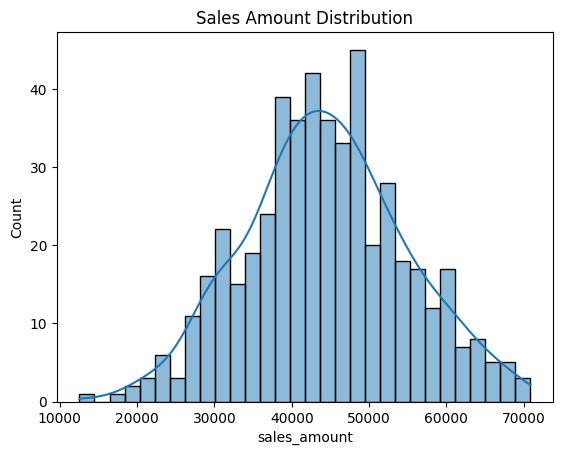

In [21]:
# Sales Distribution
sns.histplot(df['sales_amount'], kde=True, bins=30)
plt.title("Sales Amount Distribution")
plt.show()

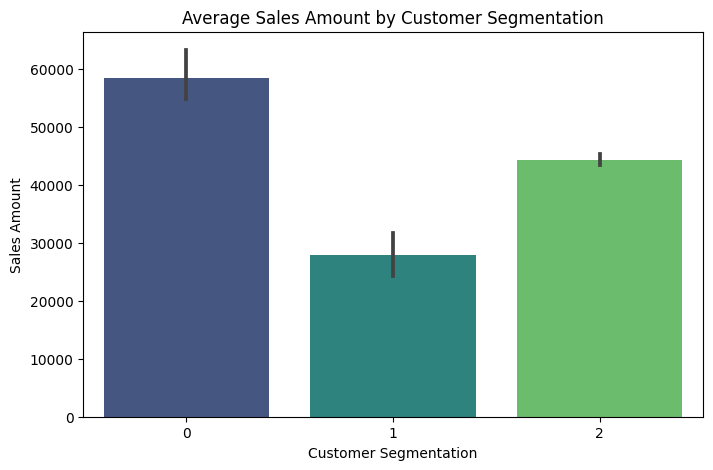

In [32]:
#  Bar Plot - Average Sales by Customer Segmentation
plt.figure(figsize=(8, 5))
sns.barplot(x='customer_segmentation', y='sales_amount', data=df, palette='viridis')
plt.title('Average Sales Amount by Customer Segmentation')
plt.xlabel('Customer Segmentation')
plt.ylabel('Sales Amount')
plt.show()


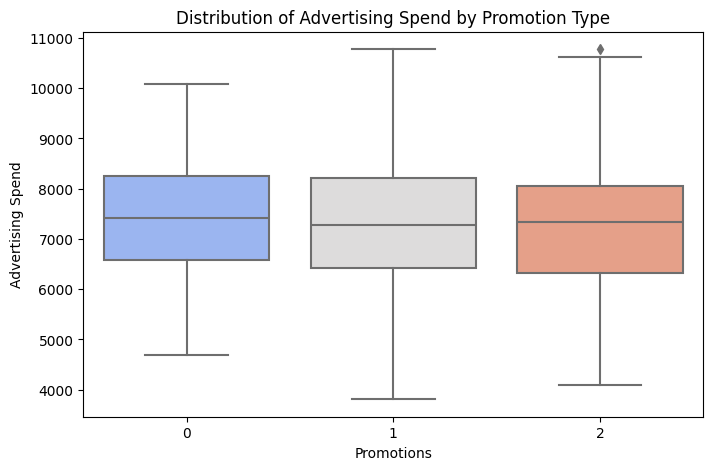

In [33]:
#  Box Plot - Advertising Spend by Promotion Type
plt.figure(figsize=(8, 5))
sns.boxplot(x='promotions', y='advertising_spend', data=df, palette='coolwarm')
plt.title('Distribution of Advertising Spend by Promotion Type')
plt.xlabel('Promotions')
plt.ylabel('Advertising Spend')
plt.show()

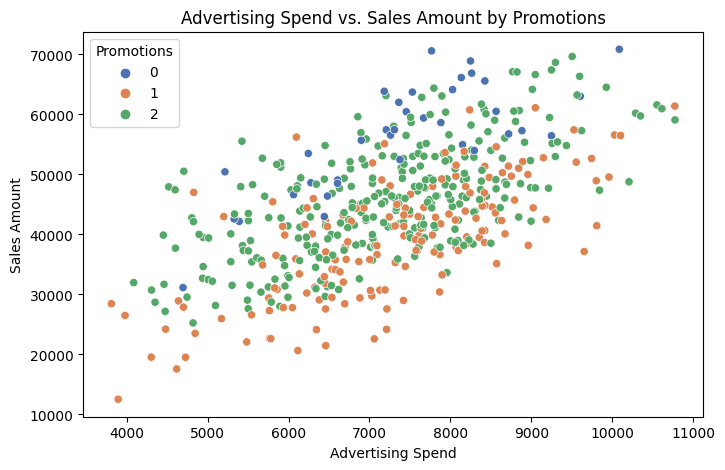

In [38]:
# 3️⃣ Scatter Plot - Advertising Spend vs. Promotions
plt.figure(figsize=(8, 5))
sns.scatterplot(x='advertising_spend', y='sales_amount', hue='promotions', data=df, palette='deep')
plt.title('Advertising Spend vs. Sales Amount by Promotions')
plt.xlabel('Advertising Spend')
plt.ylabel('Sales Amount')
plt.legend(title='Promotions')
plt.show()

## Feature Engineering & Encoding

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [26]:
# Label Encode Categorical Features
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # 0 = Male, 1 = Female
df['promotions'] = le.fit_transform(df['promotions'])
df['customer_segmentation'] = le.fit_transform(df['customer_segmentation'])

# Select Features & Target
X = df[['gender', 'age', 'annual Salary', 'credit card debt', 'net worth', 
        'advertising_spend', 'promotions', 'customer_segmentation']]
y = df['sales_amount']  # Target variable

# Split into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Feature Engineering & Encoding completed successfully!")

Feature Engineering & Encoding completed successfully!


##  Train Machine Learning Model

In [27]:
print(X_train.shape)  # Check if X_train is defined
print(y_train.shape)  # Check if y_train is defined


(395, 8)
(395,)


In [28]:
from sklearn.model_selection import train_test_split

# Select Features & Target
X = df[['gender', 'age', 'annual Salary', 'credit card debt', 'net worth', 
        'sales_amount', 'advertising_spend', 'promotions', 'customer_segmentation']]
y = df['sales_amount']  # Make sure this column exists

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

